In [1]:
from tensorflow.keras.models import load_model

model = load_model("Final_pushup_cnn_Bilstm_model.keras")
print("Model loaded successfully.")

Model loaded successfully.


In [2]:
import os

# Define dataset path (Change this to your local path)
dataset_path = r"C:\Users\Fatim\.cache\kagglehub\datasets\mohamadashrafsalama\pushup\versions\1"

In [3]:
# List folders
folders = os.listdir(dataset_path)
print("Dataset Folders:", folders)

Dataset Folders: ['Correct sequence', 'labels', 'Wrong sequence']


In [4]:
import numpy as np

# Define path to label files (adjust as needed)
labels_path = os.path.join(dataset_path, "labels")
correct_labels_file = os.path.join(labels_path, "correct.npy")
incorrect_labels_file = os.path.join(labels_path, "incorrect.npy")

In [5]:
# Load numpy files
correct_data = np.load(correct_labels_file, allow_pickle=True)
incorrect_data = np.load(incorrect_labels_file, allow_pickle=True)

In [6]:
# Choose one sample for testing
pose_sequence = correct_data[0]  # shape: (150, 66)

# Verify shape
print("Pose sequence shape:", pose_sequence.shape)


Pose sequence shape: (150, 66)


In [7]:
# Define keypoint indices based on MediaPipe
LEFT_SHOULDER = 11 * 2
LEFT_ELBOW = 13 * 2
LEFT_WRIST = 15 * 2
RIGHT_SHOULDER = 12 * 2
RIGHT_ELBOW = 14 * 2
RIGHT_WRIST = 16 * 2

# Helper function to calculate angle between three points
def calculate_angle(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    magnitude = np.linalg.norm(v1) * np.linalg.norm(v2)
    if magnitude == 0:
        return 0
    angle = np.arccos(dot_product / magnitude) * (180.0 / np.pi)
    return angle

# Compute features
angles = []
symmetry = []
velocity = []

for i in range(len(pose_sequence)):
    frame = pose_sequence[i]
    
    left_elbow_angle = calculate_angle(frame[LEFT_SHOULDER:LEFT_SHOULDER+2],
                                       frame[LEFT_ELBOW:LEFT_ELBOW+2],
                                       frame[LEFT_WRIST:LEFT_WRIST+2])
    
    right_elbow_angle = calculate_angle(frame[RIGHT_SHOULDER:RIGHT_SHOULDER+2],
                                        frame[RIGHT_ELBOW:RIGHT_ELBOW+2],
                                        frame[RIGHT_WRIST:RIGHT_WRIST+2])
    
    angles.append([left_elbow_angle, right_elbow_angle])
    symmetry.append(abs(left_elbow_angle - right_elbow_angle))

angles = np.array(angles)
symmetry = np.array(symmetry)

# Velocity is change in angle over time
velocity = np.abs(np.diff(angles, axis=0))
velocity = np.vstack((np.zeros((1, 2)), velocity))  # Pad to match frame count

feedback = []
for i in range(len(angles)):
    left, right = angles[i]
    sym = symmetry[i]
    vel = velocity[i]
    
    issues = []
    if left > 170 or right > 170:
        issues.append("Elbows overextended")
    if sym > 15:
        issues.append("Asymmetrical movement")
    if np.any(vel > 20):
        issues.append("Movement too fast")
    
    if not issues:
        feedback.append(f"Frame {i+1}: Good form")
    else:
        feedback.append(f"Frame {i+1}: " + ", ".join(issues))



In [8]:
feedback[:]

['Frame 1: Elbows overextended',
 'Frame 2: Elbows overextended',
 'Frame 3: Elbows overextended',
 'Frame 4: Elbows overextended',
 'Frame 5: Elbows overextended',
 'Frame 6: Elbows overextended',
 'Frame 7: Elbows overextended',
 'Frame 8: Elbows overextended',
 'Frame 9: Good form',
 'Frame 10: Good form',
 'Frame 11: Good form',
 'Frame 12: Good form',
 'Frame 13: Good form',
 'Frame 14: Good form',
 'Frame 15: Asymmetrical movement',
 'Frame 16: Asymmetrical movement',
 'Frame 17: Asymmetrical movement',
 'Frame 18: Asymmetrical movement',
 'Frame 19: Asymmetrical movement',
 'Frame 20: Asymmetrical movement',
 'Frame 21: Asymmetrical movement',
 'Frame 22: Asymmetrical movement',
 'Frame 23: Asymmetrical movement',
 'Frame 24: Asymmetrical movement',
 'Frame 25: Asymmetrical movement',
 'Frame 26: Asymmetrical movement',
 'Frame 27: Good form',
 'Frame 28: Good form',
 'Frame 29: Good form',
 'Frame 30: Good form',
 'Frame 31: Asymmetrical movement',
 'Frame 32: Good form',
 'Fra

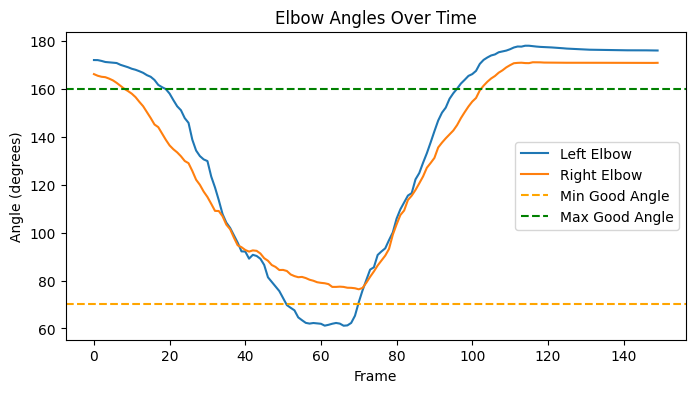

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(angles[:, 0], label="Left Elbow")
plt.plot(angles[:, 1], label="Right Elbow")
plt.axhline(70, color='orange', linestyle='--', label="Min Good Angle")
plt.axhline(160, color='green', linestyle='--', label="Max Good Angle")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.title("Elbow Angles Over Time")
plt.legend()
plt.show()

In [10]:
feedback = []

for i in range(len(angles)):
    left, right = angles[i]
    sym = symmetry[i]
    vel = velocity[i]
    
    issues = []

    # Elbow angle correction suggestions
    if left > 170:
        issues.append(f"Left elbow too extended ({left:.1f} degree), aim for ~110 degree")
    elif left < 80:
        issues.append(f"Left elbow too bent ({left:.1f} degree), aim for ~110 degree")

    if right > 170:
        issues.append(f"Right elbow too extended ({right:.1f} degree), aim for ~110 degree")
    elif right < 80:
        issues.append(f"Right elbow too bent ({right:.1f} degree), aim for ~110 degree")

    # Symmetry feedback
    if sym > 15:
        issues.append("Asymmetrical movement")

    # Velocity feedback
    if np.any(vel > 20):
        issues.append("Movement too fast")

    # Combine feedback
    if not issues:
        feedback.append(f"Frame {i+1}: Good form")
    else:
        feedback.append(f"Frame {i+1}: " + ", ".join(issues))

In [11]:
feedback[:]

['Frame 1: Left elbow too extended (172.1 degree), aim for ~110 degree',
 'Frame 2: Left elbow too extended (172.1 degree), aim for ~110 degree',
 'Frame 3: Left elbow too extended (171.8 degree), aim for ~110 degree',
 'Frame 4: Left elbow too extended (171.3 degree), aim for ~110 degree',
 'Frame 5: Left elbow too extended (171.2 degree), aim for ~110 degree',
 'Frame 6: Left elbow too extended (171.0 degree), aim for ~110 degree',
 'Frame 7: Left elbow too extended (170.9 degree), aim for ~110 degree',
 'Frame 8: Left elbow too extended (170.2 degree), aim for ~110 degree',
 'Frame 9: Good form',
 'Frame 10: Good form',
 'Frame 11: Good form',
 'Frame 12: Good form',
 'Frame 13: Good form',
 'Frame 14: Good form',
 'Frame 15: Asymmetrical movement',
 'Frame 16: Asymmetrical movement',
 'Frame 17: Asymmetrical movement',
 'Frame 18: Asymmetrical movement',
 'Frame 19: Asymmetrical movement',
 'Frame 20: Asymmetrical movement',
 'Frame 21: Asymmetrical movement',
 'Frame 22: Asymmetri

In [12]:
import cv2
import matplotlib.pyplot as plt

def overlay_pose_with_feedback(frame, keypoints, feedback_text, title="Pose with Feedback"):
    frame_copy = frame.copy()
    
    h, w, _ = frame.shape
    
    # Draw keypoints
    for x, y in keypoints:
        cx = int(x * w)
        cy = int(y * h)
        cv2.circle(frame_copy, (cx, cy), 6, (255, 0, 0), -1)

    # Draw skeleton connections (optional)
    for p1, p2 in POSE_CONNECTIONS:
        if p1 < len(keypoints) and p2 < len(keypoints):
            x1, y1 = keypoints[p1]
            x2, y2 = keypoints[p2]
            pt1 = (int(x1 * w), int(y1 * h))
            pt2 = (int(x2 * w), int(y2 * h))
            cv2.line(frame_copy, pt1, pt2, (0, 255, 0), 2)

    # Add feedback text at the top-left corner
    y_offset = 30
    for i, line in enumerate(feedback_text.split(", ")):
        cv2.putText(frame_copy, line, (10, y_offset + i*25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [13]:
import cv2

def extract_frame(video_path, frame_num=50):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    else:
        raise ValueError("Could not extract frame.")

# Replace with your actual video path
video_path = r"C:\Users\Fatim\OneDrive - Noroff Education AS\Courses@Bachelors\Bachelor Project\LSTM_Exercise_Classification_Push-Up_Videos\Correct sequence\Copy of push up 1.mp4"
frame_50 = extract_frame(video_path, frame_num=50)


In [14]:
# Assuming you have correct_data or incorrect_data as (samples, 150, 66)
keypoints_50 = correct_data[0, 50].reshape(33, 2)  # Example for first sample, frame 50

In [15]:
# MediaPipe Pose keypoint connections
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),     # Right arm
    (0, 4), (4, 5), (5, 6), (6, 8),     # Left arm
    (9, 10), (11, 12),                 # Mid body
    (11, 13), (13, 15), (15, 17),      # Right leg
    (12, 14), (14, 16), (16, 18),      # Left leg
    (11, 23), (12, 24), (23, 24),      # Hips
    (23, 25), (25, 27), (24, 26), (26, 28),  # Legs
    (27, 29), (29, 31), (28, 30), (30, 32)   # Feet
]


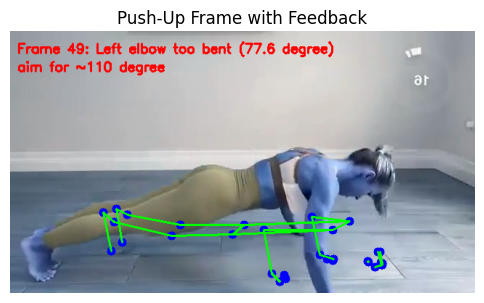

In [16]:
overlay_pose_with_feedback(frame_50, keypoints_50, feedback[48], title="Push-Up Frame with Feedback")